In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [87]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 40

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [17]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0]


In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[146. 141. 148.]
  [149. 144. 151.]
  [147. 142. 149.]
  ...
  [189. 186. 193.]
  [186. 183. 190.]
  [184. 181. 188.]]

 [[161. 156. 163.]
  [160. 155. 162.]
  [155. 150. 157.]
  ...
  [189. 186. 193.]
  [186. 183. 190.]
  [184. 181. 188.]]

 [[144. 139. 146.]
  [142. 137. 144.]
  [140. 135. 142.]
  ...
  [190. 187. 194.]
  [188. 185. 192.]
  [186. 183. 190.]]

 ...

 [[149. 143. 145.]
  [153. 147. 149.]
  [158. 152. 154.]
  ...
  [177. 174. 183.]
  [174. 171. 180.]
  [172. 169. 178.]]

 [[143. 135. 133.]
  [153. 145. 143.]
  [162. 156. 156.]
  ...
  [173. 170. 179.]
  [172. 169. 178.]
  [173. 170. 179.]]

 [[143. 135. 132.]
  [143. 135. 132.]
  [141. 136. 133.]
  ...
  [159. 156. 165.]
  [161. 158. 167.]
  [164. 161. 170.]]]


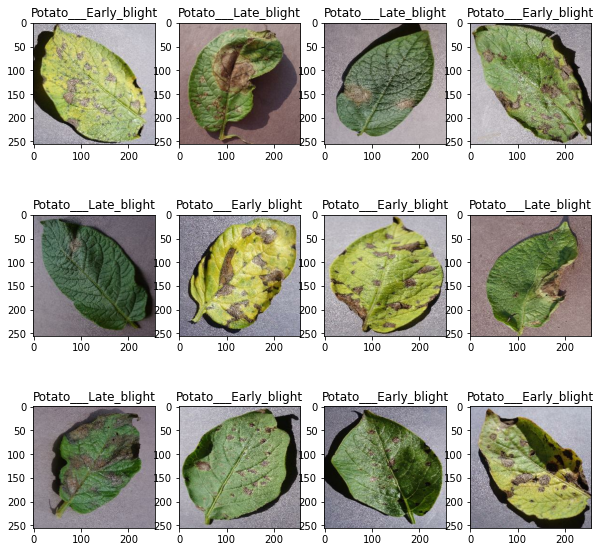

In [52]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
#         plt.axis("off")

In [55]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [56]:
train_ds = dataset.take(54)
len(train_ds)

54

In [57]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [59]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [60]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [61]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [64]:
def get_partition_dataset_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [65]:
train_ds, val_ds, test_ds = get_partition_dataset_tf(dataset)

In [66]:
len(train_ds)

54

In [67]:
len(val_ds)

6

In [68]:
len(test_ds)

8

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [89]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (32, 516128)              0         
                                                                 
 dense_2 (Dense)             (32, 64)                  33032256  
                                                      

In [90]:
model.compile(
    optimizer="adam",
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [91]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data= val_ds
)

Epoch 1/40
54/54 [==============================] - 69s 1s/step - loss: 0.9088 - accuracy: 0.4566 - val_loss: 0.8601 - val_accuracy: 0.6354
Epoch 2/40
54/54 [==============================] - 64s 1s/step - loss: 0.7893 - accuracy: 0.6250 - val_loss: 0.6679 - val_accuracy: 0.7240
Epoch 3/40
54/54 [==============================] - 65s 1s/step - loss: 0.5295 - accuracy: 0.7535 - val_loss: 0.4931 - val_accuracy: 0.8021
Epoch 4/40
54/54 [==============================] - 139s 3s/step - loss: 0.4014 - accuracy: 0.8264 - val_loss: 0.4781 - val_accuracy: 0.8177
Epoch 5/40
54/54 [==============================] - 67s 1s/step - loss: 0.3218 - accuracy: 0.8733 - val_loss: 0.4046 - val_accuracy: 0.8125
Epoch 6/40
54/54 [==============================] - 66s 1s/step - loss: 0.2300 - accuracy: 0.9086 - val_loss: 0.1980 - val_accuracy: 0.9323
Epoch 7/40
54/54 [==============================] - 66s 1s/step - loss: 0.1880 - accuracy: 0.9265 - val_loss: 0.2893 - val_accuracy: 0.8750
Epoch 8/40
54/54 [=

In [92]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 356ms/step - loss: 0.0508 - accuracy: 0.9883


scores

In [93]:
scores

[0.05081263929605484, 0.98828125]

In [94]:
history

In [95]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [98]:
type(history.history["loss"])

list

In [99]:
len(history.history['loss'])

40

In [100]:
history.history['loss'][:5]

[0.9088046550750732,
 0.7893268465995789,
 0.5295308232307434,
 0.40141206979751587,
 0.32178589701652527]

In [101]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [102]:
acc

[0.4565972089767456,
 0.625,
 0.7534722089767456,
 0.8263888955116272,
 0.8732638955116272,
 0.9085648059844971,
 0.9265046119689941,
 0.9444444179534912,
 0.9641203880310059,
 0.9542824029922485,
 0.9554398059844971,
 0.984375,
 0.9866898059844971,
 0.9878472089767456,
 0.9942129850387573,
 0.984375,
 0.9861111044883728,
 0.9936342835426331,
 0.9988425970077515,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [103]:
val_acc

[0.6354166865348816,
 0.7239583134651184,
 0.8020833134651184,
 0.8177083134651184,
 0.8125,
 0.9322916865348816,
 0.875,
 0.9583333134651184,
 0.9375,
 0.953125,
 0.9739583134651184,
 0.9895833134651184,
 0.9583333134651184,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9583333134651184,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9947916865348816]

In [104]:
val_loss

[0.8601437211036682,
 0.6679009795188904,
 0.49307212233543396,
 0.47805824875831604,
 0.4046385586261749,
 0.19795072078704834,
 0.2892830967903137,
 0.11074874550104141,
 0.13670732080936432,
 0.13054318726062775,
 0.07844137400388718,
 0.06986769288778305,
 0.10855872184038162,
 0.09504484385251999,
 0.10344087332487106,
 0.050266727805137634,
 0.14184671640396118,
 0.04688311740756035,
 0.1057174801826477,
 0.07587236911058426,
 0.08143191039562225,
 0.08234327286481857,
 0.08451134711503983,
 0.08561849594116211,
 0.08747030049562454,
 0.08787286281585693,
 0.08978090435266495,
 0.0913737490773201,
 0.09194391965866089,
 0.09286299347877502,
 0.09448933601379395,
 0.09527377039194107,
 0.09576651453971863,
 0.09707089513540268,
 0.09752357006072998,
 0.0981413722038269,
 0.09900432825088501,
 0.0990021601319313,
 0.10027001053094864,
 0.10140392184257507]

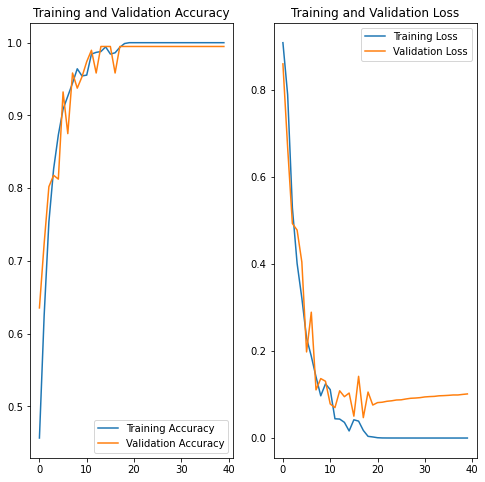

In [105]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
import numpy as np

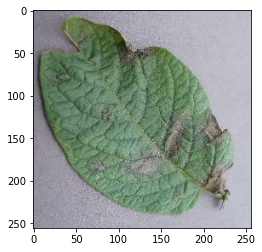

In [109]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [108]:
for image_batch, label_batch in test_ds.take(1):
    print(image_batch[0].numpy())

[[[164. 157. 165.]
  [162. 155. 163.]
  [158. 151. 159.]
  ...
  [159. 157. 170.]
  [157. 155. 168.]
  [154. 152. 165.]]

 [[161. 154. 162.]
  [159. 152. 160.]
  [156. 149. 157.]
  ...
  [157. 155. 168.]
  [155. 153. 166.]
  [152. 150. 163.]]

 [[156. 149. 157.]
  [154. 147. 155.]
  [153. 146. 154.]
  ...
  [154. 152. 165.]
  [153. 151. 164.]
  [151. 149. 162.]]

 ...

 [[ 99.  89.  97.]
  [103.  93. 101.]
  [105.  95. 103.]
  ...
  [114. 106. 117.]
  [116. 108. 119.]
  [117. 109. 120.]]

 [[110. 100. 108.]
  [110. 100. 108.]
  [109.  99. 107.]
  ...
  [114. 106. 117.]
  [113. 105. 116.]
  [112. 104. 115.]]

 [[110. 100. 108.]
  [106.  96. 104.]
  [102.  92. 100.]
  ...
  [115. 107. 118.]
  [110. 102. 113.]
  [107.  99. 110.]]]


first image to predict
actual label is  Potato___Late_blight
1/1 [==============================] - 0s 451ms/step
[1.2634702e-11 1.0000000e+00 1.4357698e-09]


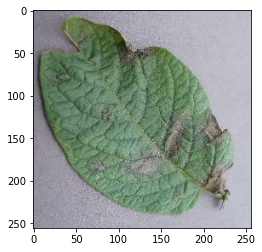

In [117]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label is ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])

In [127]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


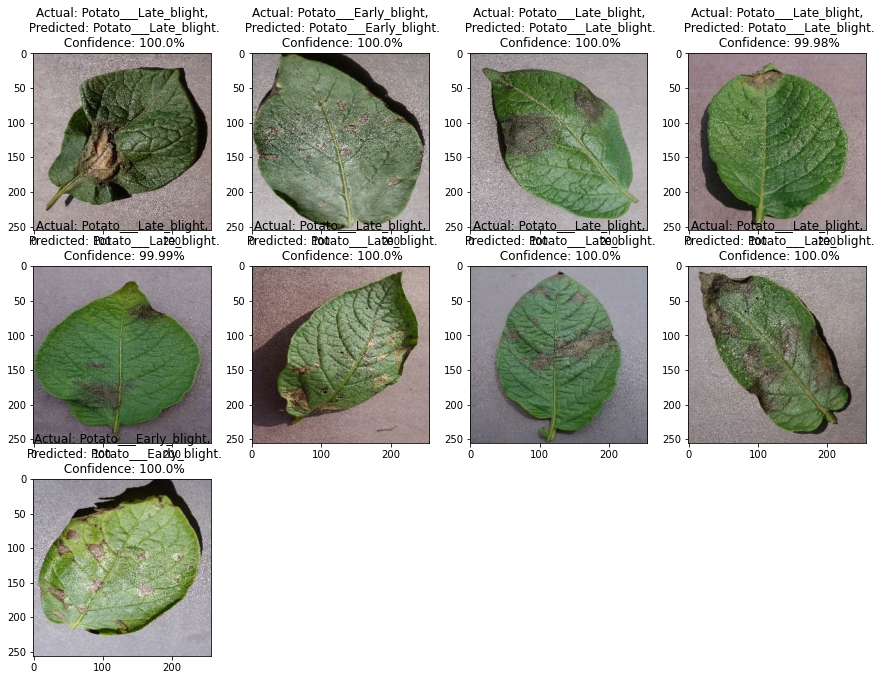

In [136]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
#         plt.axis("off")
